# SSD Object Detection

In [1]:
%matplotlib inline

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from matplotlib import pyplot as plt
from ssd import SSD300
import data

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## 1. Build SSD300 and Load Weights

In [3]:
net = SSD300('test', 300, 21)    # initialize SSD
net.load_weights('./SSD.pth')

Finished!


/datasets/home/home-02/53/653/w1huang/SSD/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


## 2. Load Image for demo use img_id

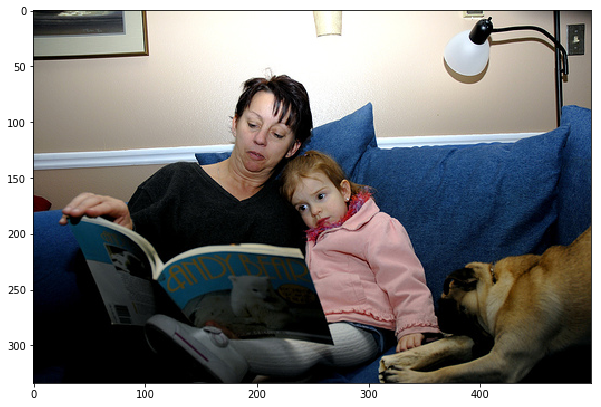

In [23]:
from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# specify dataset ('test', 'val', 'train') 
testset = VOCDetection(VOC_ROOT, [('2012', 'val')], None, VOCAnnotationTransform())
img_id = 69
image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## 3.  Pass the image to the net

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


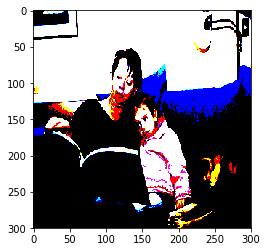

In [24]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

xx = Variable(x.unsqueeze(0))     
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

## View detections and results

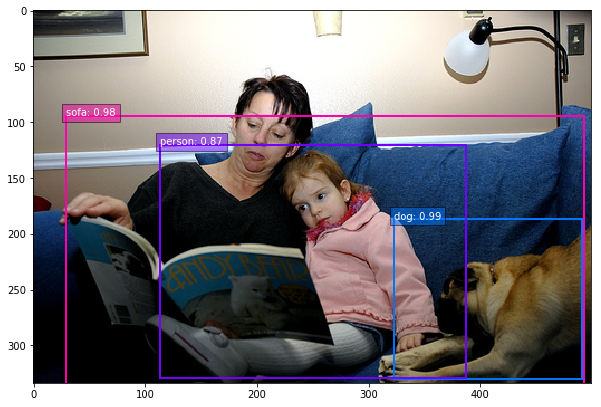

In [26]:
# display class with confidence level greater than
confi_level=0.6

plt.figure(figsize=(10,10))
plt.imshow(rgb_image)  # plot the image for matplotlib
ax = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= confi_level:
        score = detections[0,i,j,0]
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        data.draw_bbox(ax,coords,i,score)
        j+=1